In [1]:
## microfinancenance network 
## data from BANERJEE, CHANDRASEKHAR, DUFLO, JACKSON 2012

## data on 8622 households
hh <- read.csv("microfinance_households.csv", row.names="hh")
hh$village <- factor(hh$village)


In [2]:
## We'll kick off with a bunch of network stuff.
## This will be covered in more detail in later lectures.
## Get igraph off of CRAN if you don't have it
# install.packages("igraph")
# ## this is a tool for network analysis
# ## (see http://igraph.sourceforge.net/)
library(igraph)

Warning message:
"package 'igraph' was built under R version 3.6.2"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



In [3]:
edges <- read.table("microfinance_edges.txt", colClasses="character")
## edges holds connections between the household ids
hhnet <- graph.edgelist(as.matrix(edges))
hhnet <- as.undirected(hhnet) # two-way connections.
## igraph is all about plotting.  
V(hhnet) ## our 8000+ household vertices

+ 8182/8182 vertices, named, from 4fb9e91:
   [1] 1002  1001  1020  1042  1053  1163  1003  1004  1026  1029  1076  1159 
  [13] 1106  1031  1048  1081  1006  1005  1008  1016  1021  1024  1089  1103 
  [25] 1007  1019  1155  1015  1040  1044  1045  1078  1088  1110  1115  1140 
  [37] 1145  1009  1018  1060  1064  1073  1153  1067  1099  1010  1162  1012 
  [49] 1143  1013  1023  1028  1034  1065  1117  1139  1154  1157  1173  1014 
  [61] 1068  1071  1148  1017  1036  1062  1112  1118  1120  1129  1134  1165 
  [73] 1183  1126  1122  1049  1058  1093  1108  1114  1119  1022  1043  1079 
  [85] 1033  1102  1104  1105  1152  1169  1171  1025  1027  1147  1032  1035 
  [97] 1037  1039  1041  1113  1174  1069  1116  1132  1178  1146  1080  1086 
 [109] 1101  1172  1059  1141  1142  1038  1094  1052  1092  1082  1095  1158 
+ ... omitted several vertices

In [4]:
## Each vertex (node) has some attributes, and we can add more.
V(hhnet)$village <- as.character(hh[V(hhnet),'village'])
## we'll color them by village membership
vilcol <- rainbow(nlevels(hh$village))
names(vilcol) <- levels(hh$village)
V(hhnet)$color = vilcol[V(hhnet)$village]
## drop HH labels from plot
V(hhnet)$label=NA

In [5]:
######  now, on to the HW

## match id's
matches <- match(rownames(hh), V(hhnet)$name)

## calculate the 'degree' of each hh: 
##number of commerce/friend/family connections
degree <- degree(hhnet)[matches]
names(degree) <- rownames(hh)
degree[is.na(degree)] <- 0 # unconnected houses, not in our graph


# Question 2

In [6]:
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [8]:
################################################################################
#Question 2
################################################################################

q2_x <- hh[,-1]

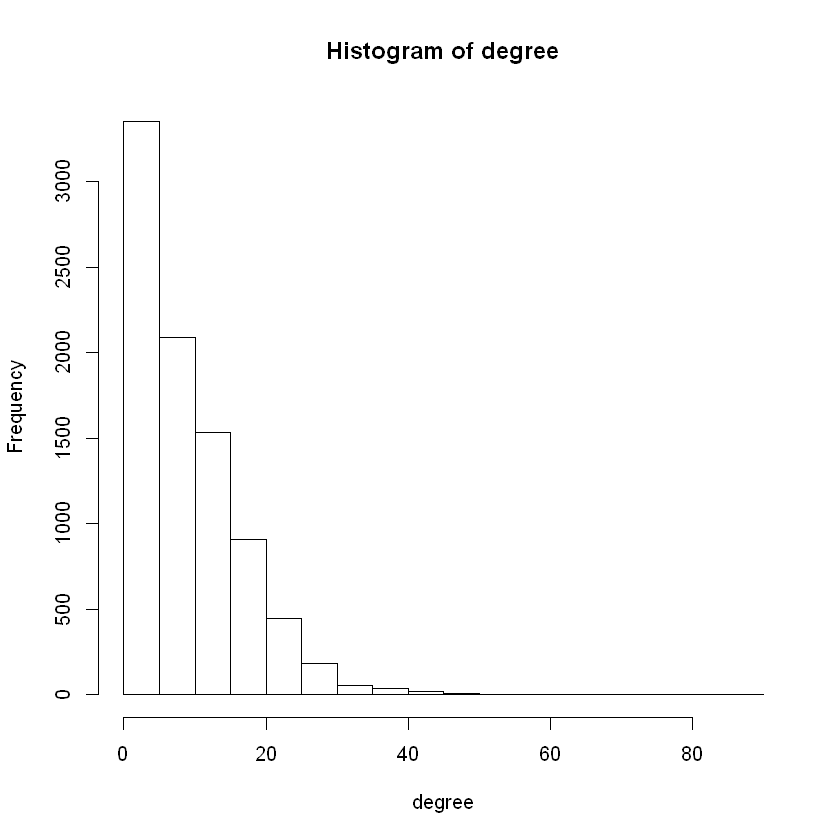

In [9]:
#Formating Y
q2_y <- data.frame(degree)
hist(degree)
q2_y <- log(1+q2_y)
q2_y <- model.matrix( ~ .-1, q2_y)


In [10]:
#Formating X
q2_x <- sparse.model.matrix( ~ .^2, q2_x)

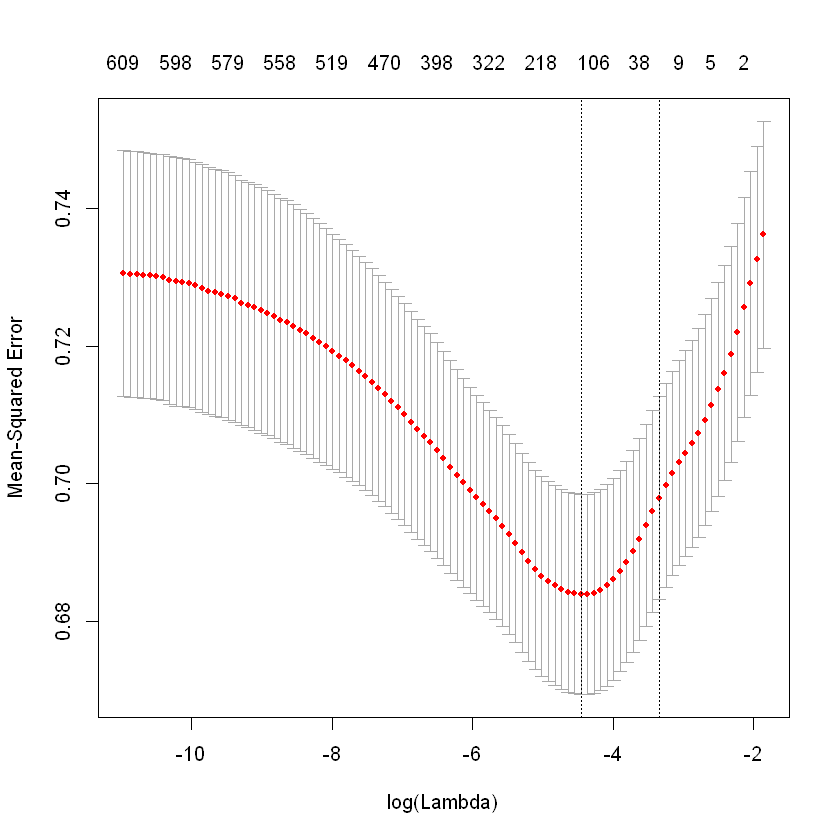

In [11]:
#Lasso+CV for X^2 to Degree
set.seed(1)
cv.fit <- cv.glmnet(x=q2_x,y=q2_y,alpha=1,type.measure="mse",family="gaussian")
plot(cv.fit)

In [12]:
#Best Lambda
best_lambda <- cv.fit$lambda.min

In [13]:
#Use the best lambda on the lasso regression 
treat <- glmnet(x=q2_x,y=q2_y,lambda.min.ratio=best_lambda)

In [14]:
#Predict the d_hat
d_hat <- predict(treat,q2_x,type='response',s=best_lambda)

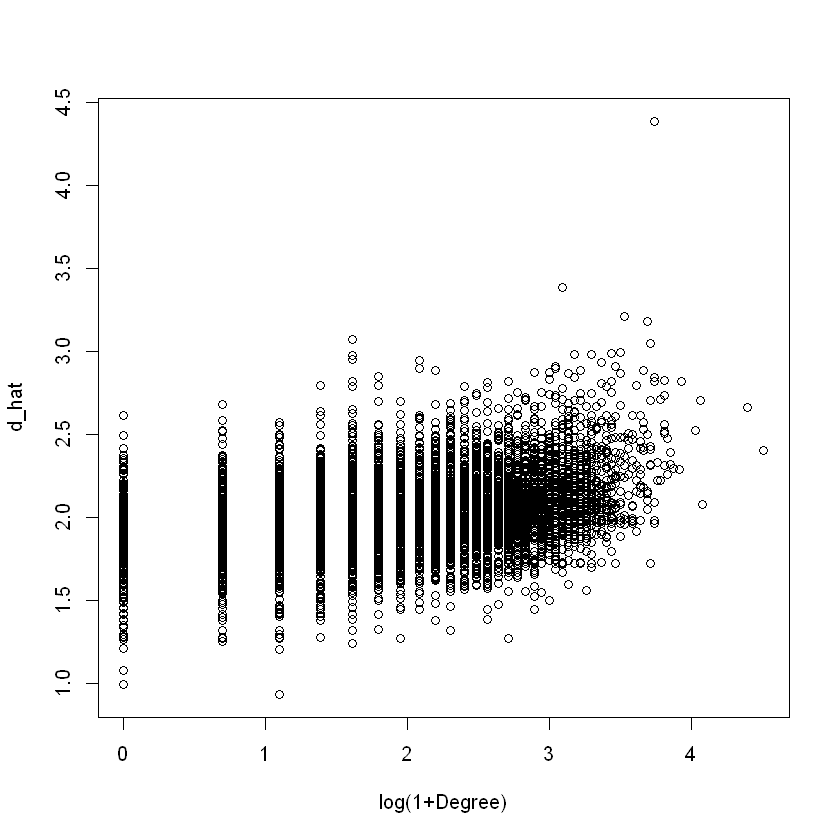

In [15]:
plot(q2_y,d_hat,xlab='log(1+Degree)')

In [16]:
#R squared for the X^2 regress to degree
rss <- sum((d_hat - q2_y) ^ 2)
tss <- sum((q2_y - mean(q2_y)) ^ 2)
1 - rss/tss

[1] 0.09953836

# Question 3

In [17]:
##########################################################################
#Question 3
##########################################################################

#Set the unpenalty factors
factor <- c(1,0,rep(1,ncol(q2_x)))

In [18]:
#Lasso regression with degree, d_hat, and X^2 
causal <- glmnet(x=cbind(q2_y,d_hat,q2_x[,-1]),y=hh[,1], penalty.factor=factor,family="binomial")

In [19]:
#Use AICc to find the best model's index
tLL <- causal$nulldev - deviance(causal)
k <- causal$df
n <- causal$nobs
AICc <- -tLL+2*k+2*k*(k+1)/(n-k-1)


In [20]:
index_best <- which.min(AICc)

In [21]:
#Degree's coefficient from the best model
coef(causal)[2,index_best]

[1] 0.132751

# Question 4

In [22]:
###########################################################################
#Question 4
###########################################################################

#Lasso regression with only degree and X^2
q4_causal <- glmnet(x=cbind(q2_y,q2_x[,-1]),y=hh[,1],family="binomial")
q4_coef <- coef(q4_causal)

In [23]:
#Use AICc to find the best model 
tLL <- q4_causal$nulldev - deviance(q4_causal)
k <- q4_causal$df
n <- q4_causal$nobs
AICc <- -tLL+2*k+2*k*(k+1)/(n-k-1)
index_best <- which.min(AICc)

In [24]:
#Degree's coefficient from the best model
q4_coef[2,index_best]

[1] 0.1306922

# Question 5

In [25]:
###########################################################################
#Question 5
###########################################################################

#Bootstrap 
gamma <- c()
n <- nrow(q2_x)
factor <- c(1,0,rep(1,ncol(q2_x)))
for (b in 1:100) {
    ib <- sample(1:n,n,replace=TRUE)
    fb <- glmnet(cbind(q2_y[ib],d_hat[ib,1],q2_x[ib,-1]),hh[ib,1],penalty.factor=factor,family="binomial")##ib
    tLL <- fb$nulldev - deviance(fb)
    k <- fb$df
    n <- fb$nobs
    AICc <- -tLL+2*k+2*k*(k+1)/(n-k-1)
    aicc <- which.min(AICc)
    gamma <- rbind(gamma,coef(fb)[2,aicc])}





In [35]:
left <- quantile(gamma,0.025)
right <- quantile(gamma,0.975)

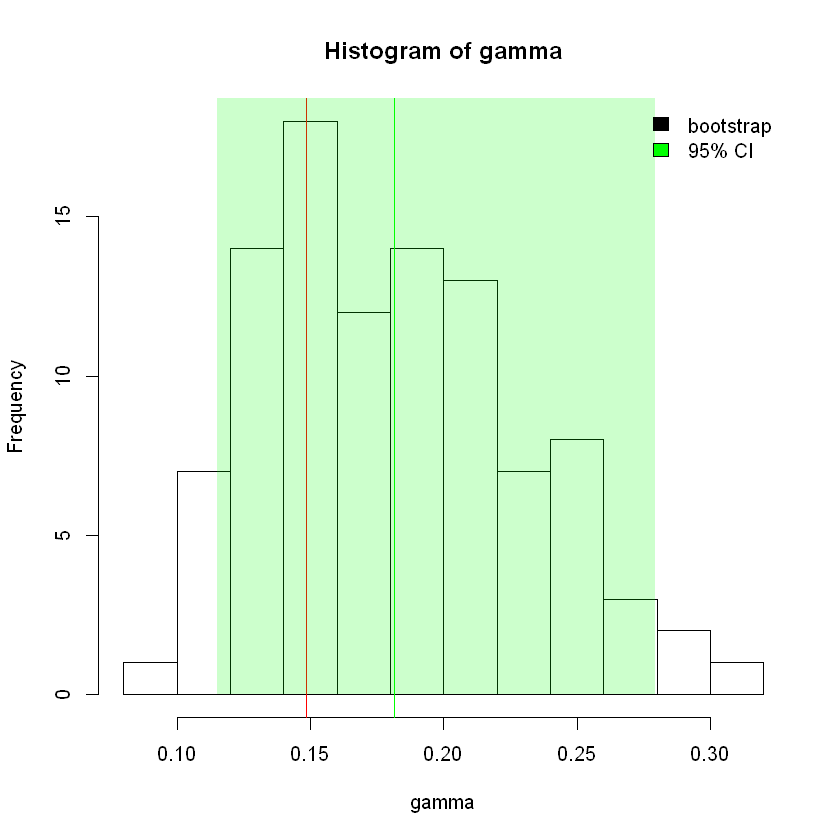

In [38]:
hist(gamma)
abline(v=coef(causal)[2,25],col=2)
polygon(x=c(rep(left,2),rep(right,2)),
        y=c(0,100,100,0), col=rgb(0,1,0,.2), border=NA)
abline(v=mean(gamma),col="green")
legend("topright", fill=c(1,"green"), bty="n",
       legend=c("bootstrap","95% CI") )